# Problem 1

1. a) 
$\alpha$ is the constant return of the N stocks, unrelated to the two factors' beta
$\beta$ is the sensitivity of the N stocks to the returns of the two factors, S&P500 index and Bitcoin.
$f_t$ is the returns of the two factors, S&P500 index and Bitcoin, at time t.
$\epsilon_t$ is the residual ramdom number with mean 0. 

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import cvxpy as cp
yf.pdr_override()
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
# 1.(b)
stocks = ['TSLA', 'AMZN', 'EBAY', 'AAPL', 'MSFT', 'META', 'GOOGL',
          'NFLX', 'IBM', 'NVDA']
indices = ['^GSPC', 'BTC-USD']
N = len(stocks)
prices = pdr.get_data_yahoo(stocks, start="2019-01-01", end="2022-12-31")[['Adj Close']].xs('Adj Close', axis = 1)
factors = pdr.get_data_yahoo(indices, start="2019-01-01", end="2022-12-31")[['Adj Close']].xs('Adj Close', axis = 1)

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  2 of 2 completed


In [3]:
factors.dropna(inplace = True)    
factors = factors.apply(np.log).apply(np.diff)
T = factors.shape[0]
X = prices.apply(np.log).apply(np.diff)
X['Date'] = prices.index.values[1:]
X.set_index('Date', inplace = True)
X

,AAPL,AMZN,EBAY,GOOGL,IBM,META,MSFT,NFLX,NVDA,TSLA
Date,,,,,,,,,,
2019-01-03,-0.104924,-0.025566,-0.018542,-0.028086,-0.020165,-0.029469,-0.037482,0.013139,-0.062319,-0.031978
2019-01-04,0.041803,0.048851,0.022692,0.050021,0.038314,0.046061,0.045460,0.092793,0.062099,0.056094
2019-01-07,-0.002228,0.033777,0.017112,-0.001996,0.007050,0.000725,0.001275,0.058002,0.051587,0.052935
2019-01-08,0.018884,0.016476,0.017825,0.008745,0.014119,0.031937,0.007225,0.015513,-0.025211,0.001164
2019-01-09,0.016839,0.001713,0.009620,-0.003433,0.007151,0.011857,0.014198,-0.000968,0.019476,0.009438
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.002802,0.017274,0.001245,0.016612,0.005451,0.007824,0.002265,-0.009414,-0.008709,-0.017707
2022-12-27,-0.013976,-0.026266,-0.002243,-0.020836,0.005421,-0.009876,-0.007442,-0.037267,-0.074027,-0.121138
2022-12-28,-0.031166,-0.014801,-0.004000,-0.015801,-0.016995,-0.010839,-0.010308,-0.025988,-0.006038,0.032553


In [4]:
alpha = cp.Variable((1,N))
beta = cp.Variable((N,2))
objective = cp.Minimize(cp.sum_squares(np.asarray(X) - np.ones(T).reshape([T,1]) @ alpha - np.asarray(factors) @ beta.T))
cp.Problem(objective).solve()
factor_molel = pd.DataFrame(np.hstack((alpha.value.T, beta.value)), columns = ['alpha', 'beta_Bitcoin','beta_S&P500'])
factor_molel['Stock'] = prices.columns.values
factor_molel.set_index('Stock', inplace = True)
factor_molel

,alpha,beta_Bitcoin,beta_S&P500
Stock,,,
AAPL,0.000709,-0.006548,1.228193
AMZN,-0.000376,0.030284,0.993262
EBAY,0.000082,-0.009762,0.830940
GOOGL,0.000038,0.003613,1.109195
IBM,0.000115,-0.028000,0.860261
META,-0.000666,0.018550,1.233919
MSFT,0.000395,0.007276,1.171780
NFLX,-0.000379,0.044232,0.975753
NVDA,0.000693,0.043370,1.655125


In [5]:
# 1.(c)
F = np.column_stack([np.ones(T), factors])
F

array([[ 1.        , -0.02742232, -0.02506833],
       [ 1.        ,  0.00545233,  0.0337594 ],
       [ 1.        ,  0.0425109 ,  0.00698598],
       ...,
       [ 1.        , -0.00989505, -0.01209347],
       [ 1.        ,  0.00540864,  0.01731063],
       [ 1.        , -0.0023917 , -0.00254398]])

In [6]:
# 1.(d)
# Gamma_mat = np.linalg.solve(F, X)
Gamma = X.T @ F @ np.linalg.inv(F.T @ F)
Gamma.columns = ['alpha', 'beta_Bitcoin', 'beta_S&P500']

In [7]:
Gamma

,alpha,beta_Bitcoin,beta_S&P500
AAPL,0.000709,-0.006548,1.228193
AMZN,-0.000376,0.030284,0.993262
EBAY,0.000082,-0.009762,0.830940
GOOGL,0.000038,0.003613,1.109195
IBM,0.000115,-0.028000,0.860261
META,-0.000666,0.018550,1.233919
MSFT,0.000395,0.007276,1.171780
NFLX,-0.000379,0.044232,0.975753
NVDA,0.000693,0.043370,1.655125
TSLA,0.001051,0.106543,1.347903


In [8]:
# compare the results from the two different ways
(factor_molel - Gamma).max()

alpha           1.301043e-18
beta_Bitcoin    4.857226e-17
beta_S&P500     3.330669e-16
dtype: float64

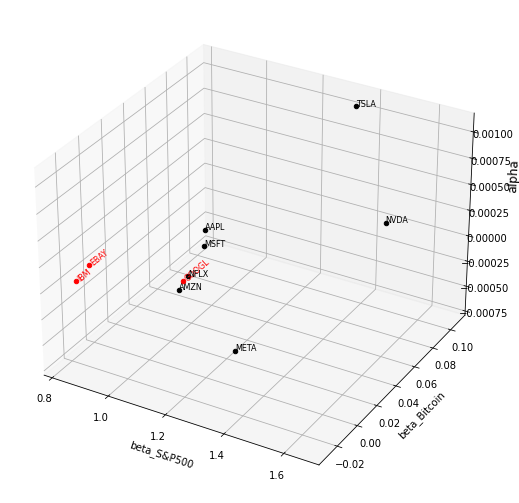

In [9]:
# 1.(e)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(projection='3d')

xs = Gamma['beta_S&P500']
ys = Gamma['beta_Bitcoin']
zs = Gamma['alpha']
labels = Gamma.index.values

for x, y, z, label in zip(xs, ys, zs, labels):
    if x < np.median(Gamma['beta_S&P500']) and \
            y < np.median(Gamma['beta_Bitcoin']) and z > 0:
        ax.text(x, y, z, label,fontsize=8, c='r', zdir = 'y')
        ax.scatter(x, y, z, c='r')
    else:
        ax.text(x, y, z, label,fontsize=8, c='k')
        ax.scatter(x, y, z, c='k')

ax.set_xlabel('beta_S&P500')
ax.set_ylabel('beta_Bitcoin')
# ax.set_zlabel('alpha')
ax.text(1.74, 0.15, 0.0002, 'alpha',fontsize=12, zdir = 'z')

plt.show()

1.(f) 
IBM, EBAT and GOOGL are less risky stocks to invest on as they have lower sentivity to the S&P500 index and Bitcoin price, also they have positive alpha, which are excess returns. 

In [10]:
# 1.(g) 
from sklearn.preprocessing import scale

K = 2
alpha = np.mean(X, axis=0)
X_ = scale(X, with_std=False)
Sigma_prev = np.zeros((N, N))
Psi = np.zeros((N, N))
Sigma = X_.T @ X_ / (T-1)
while (np.linalg.norm(Sigma - Sigma_prev)/np.linalg.norm(Sigma) > 1e-3):
  values, vectors = np.linalg.eig(Sigma - Psi)
  B = vectors[:, :K] * np.sqrt(values[:K])
  Psi = np.diag(np.diag(Sigma - B @ B.T))
  Sigma_prev = Sigma
  Sigma = B @ B.T + Psi
stat_model = pd.DataFrame(np.column_stack([alpha, B]).real, index=Gamma.index.values) 
stat_model.rename(columns = {0 : 'alpha', 1 : 'beta_1', 2 : 'beta_2'}, inplace = True)
stat_model

,alpha,beta_1,beta_2
AAPL,0.001218,-0.017702,0.003439
AMZN,0.000087,-0.017889,0.005015
EBAY,0.000419,-0.012355,0.002455
GOOGL,0.000511,-0.016121,0.005469
IBM,0.000439,-0.007453,0.002652
META,-0.000119,-0.021006,0.010673
MSFT,0.000900,-0.016752,0.004416
NFLX,0.000096,-0.021503,0.007232
NVDA,0.001454,-0.028261,0.004774
TSLA,0.001772,-0.032121,-0.027317


In [11]:
np.corrcoef(factor_molel['alpha'], stat_model['alpha'])   # 0.98
np.corrcoef(factor_molel['beta_S&P500'], stat_model['beta_2'])   # 0.79

array([[ 1.        , -0.22952926],
       [-0.22952926,  1.        ]])

The alphas in the two models have the same trend, with a correlation efficient high as 0.98
The correlation efficient of one beta (for S&P500 in the factor model) is also not low, at 0.79
The other beta in statistical factor is insignificant and not meaningful. 
The factor model in part b works better and it is more interpretable. Although the statistic model derive a factor with a meaningful  beta but we don't know what it is.

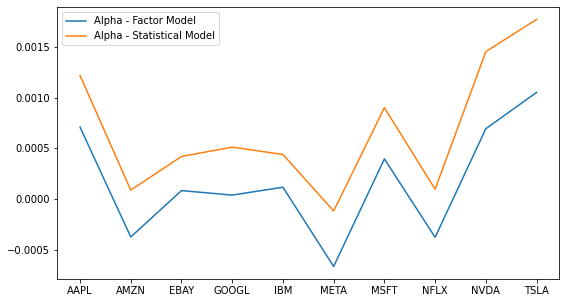

In [12]:
fig, ax = plt.subplots(figsize=(9, 5))
ln1, = ax.plot(factor_molel.index.values, factor_molel['alpha'])
ln2, = ax.plot(factor_molel.index.values, stat_model['alpha'])
plt.legend(handles = [ln1, ln2], labels = ['Alpha - Factor Model','Alpha - Statistical Model'])
plt.show()

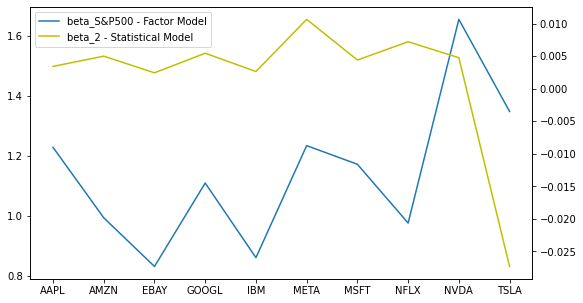

In [13]:
fig, ax = plt.subplots(figsize=(9, 5))
ln1, = ax.plot(factor_molel.index.values, factor_molel['beta_S&P500'])
ax2=ax.twinx()
ln2, = ax2.plot(factor_molel.index.values, stat_model['beta_2'], c='y')
plt.legend(handles = [ln1, ln2], labels = ['beta_S&P500 - Factor Model','beta_2 - Statistical Model'])
plt.show()

# Problem 2

In [14]:
# 2.a)
training = X[:'2021-12-31'][['AAPL','MSFT','GOOGL']]
test = X['2022-1-1':][['AAPL','MSFT','GOOGL']]
mu_s = np.mean(training, axis=0)
sigma_s = np.cov(training.T)
rho_list = [0, 0.2, 0.4, 0.6, 0.8, 1]
N = len(mu_s)
X = cp.Variable(3)
beta = 0.001
objective = cp.Minimize(X.T @ sigma_s @ X)
constraints = [X >= 0, cp.sum(X) == 1, X @ mu_s >= beta]      # np.log(1 + beta / 253)
cp.Problem(objective, constraints).solve()
W = X.value
W

array([0.14576681, 0.32967847, 0.52455472])

In [26]:
mu_s

AAPL     0.002028
MSFT     0.001634
GOOGL    0.001337
dtype: float64

In [15]:
def sharp(rho1, rho2):
    sigma = rho1 * sigma_s + (1 - rho1) * np.diag(sigma_s)
    mu = rho2 * mu_s + (1 - rho2) * np.ones(N).T @ mu_s / N * np.ones(N)    
    sharp = W.T @ mu / np.sqrt(W.T @ sigma @ W)
    return sharp

In [16]:
# 2.b)
sharps = pd.DataFrame(index = rho_list, columns = rho_list, dtype = 'float64')
for i in range(len(rho_list)):
    for j in range(len(rho_list)):
        sharps.at[rho_list[i],rho_list[j]]= sharp(rho_list[i], rho_list[j])
sharps = sharps.sort_index(axis = 0, ascending = False)
sharps

,0.0,0.2,0.4,0.6,0.8,1.0
1.0,0.093825,0.092352,0.090879,0.089406,0.087933,0.086460
0.8,0.092208,0.090760,0.089313,0.087865,0.086417,0.084970
0.6,0.090672,0.089248,0.087825,0.086401,0.084978,0.083554
0.4,0.089210,0.087809,0.086409,0.085008,0.083608,0.082207
0.2,0.087816,0.086438,0.085059,0.083680,0.082302,0.080923
0.0,0.086486,0.085129,0.083771,0.082413,0.081055,0.079698


In [17]:
sharp_max = sharps.max(axis=0).max()
sharp_max

0.09382473269068788

In [18]:
rho1_maxSharp = sharps.max(axis=1).idxmax()
rho1_maxSharp

1.0

In [19]:
rho2_maxSharp = sharps.max(axis=0).idxmax()
rho2_maxSharp

0.0

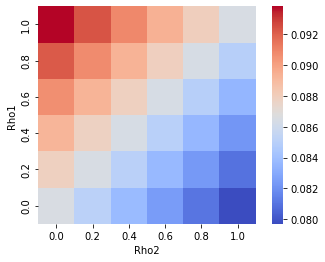

In [20]:
ax = sns.heatmap(
    sharps.sort_index(axis = 0, ascending = False), 
    cmap='coolwarm',
    square=True
)
ax.set(xlabel = rho_list)
ax.set(ylabel = rho_list)
ax.set_ylabel('Rho1')
ax.set_xlabel('Rho2')
plt.show()

In [21]:
# 2.c)
rho1 = rho1_maxSharp   # 1
rho2 = rho2_maxSharp   # 0
mu_t = np.mean(test, axis=0)
sigma_t = np.cov(test.T)
sigma = rho1 * sigma_t + (1 - rho1) * np.diag(sigma_t)
mu = rho2 * mu_t + (1 - rho2) * np.ones(N).T @ mu_t / N * np.ones(N)    
sharp = W.T @ mu / np.sqrt(W.T @ sigma @ W)
sharp

-0.0676425959373435

In [22]:
# 2.d)
rho1 = 1.0
rho2 = 1.0
sigma = rho1 * sigma_t + (1 - rho1) * np.diag(sigma_t)
mu = rho2 * mu_t + (1 - rho2) * np.ones(N).T @ mu_t / N * np.ones(N)    
sharp = W.T @ mu / np.sqrt(W.T @ sigma @ W)
sharp  

-0.0741176770149314

The sharp without shrinkage is a little decreased. With the shrinkage (rho2 = 0), in calculating sharp ratio we use the simple average return of the three stocks -0.0015, which is higher than the weighted average return -0.0016, used without shrinkage. GOOGL, taking up 52% in our porfolio but having the biggest loss among the three stocks in 2022, make the simple average better than the weight average. 

In [23]:
mu_t @ W

-0.0016460547250662844

In [24]:
np.ones(N).T @ mu_t / N

-0.001502251812829792

In [25]:
mu_t.mean()

-0.001502251812829792